# Подготовка

In [2]:
# Установка необходимых библиотек.

!pip3 install xmltodict -q
!pip3 install albumentations -q

ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 465, in read
    n = self.readinto(b)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 509, in readinto
    n = self.fp.readinto(b)
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "C:\ProgramData\Anaconda3\lib\ssl

In [5]:
# Импорт необходимых библиотек.

import xmltodict
import random
import os
import numpy as np

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader

from PIL import Image

import matplotlib.pyplot as plt

from albumentations import Compose, Resize, HorizontalFlip, RandomBrightnessContrast, BboxParams

ModuleNotFoundError: No module named 'albumentations'

Фиксируем устройство, на котором будут производиться вычисления.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Теперь возьмем небольшую часть датасета [Fruits](https://universe.roboflow.com/fruitsdetection/fruits-by-yolo) для дальнейшего изучения.

Из датасета возьмём только 4 класса изображений, чтобы снизить объём данных, с которыми мы будем работать. Данный датасет часто служит примером для демонстрации возможностей детекции, например, в статьях и демо моделей YOLO. Каждое изображение в датасете — это фото определенного фрукта или нескольких фруктов.

Данные для работы в рамках этого модуля доступны [по ссылке](https://edu.sirius.online/noo-back/files/8a3de946c0734dd18724f5fc9e089b2f35f14dfe.zip). Скачайте архив (его размер — 30 Мб), распакуйте и поместите полученную папку `data` в директорию с блокнотом Jupyter.

Посмотрим на какой-нибудь пример изображения из датасета.

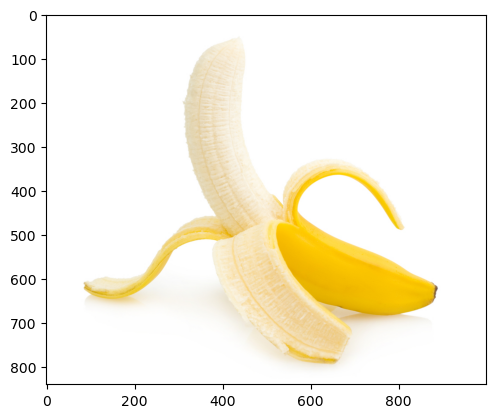

In [6]:
## import matplotlib.pyplot as plt
## from PIL import Image
name = 'banana_2'
plt.imshow(np.array(Image.open(f'dataset/fruits/train/{name}.jpg')));  ## здесь и далее заменяю data/ на dataset/fruits/

Однако в задаче детекции важно не только изображение, но и его прямоугольник. Давайте посмотрим, в каком виде он сохранен в датасете.

In [7]:
name = 'banana_2'

with open(f'dataset/fruits/train/{name}.xml') as f:
    tmp = f.read()

print(tmp)

<annotation>
	<folder>train</folder>
	<filename>banana_2.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\banana_2.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>840</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>banana</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>301</xmin>
			<ymin>57</ymin>
			<xmax>897</xmax>
			<ymax>724</ymax>
		</bndbox>
	</object>
</annotation>



По умолчанию прямоугольник сохранён в формате `xml`. Для работы с файлами `xml` мы будем использовать библиотеку `xmltodict`. Она позволяет превратить файл `xml` в обычный Python-словарь.

In [10]:
## import xmltodict

name = 'banana_2'

with open(f'dataset/fruits/train/{name}.xml') as f:
    tmp = f.read()

tmp = xmltodict.parse(tmp)

In [11]:
tmp

{'annotation': {'folder': 'train',
  'filename': 'banana_2.jpg',
  'path': 'C:\\tensorflow1\\models\\research\\object_detection\\images\\train\\banana_2.jpg',
  'source': {'database': 'Unknown'},
  'size': {'width': '1000', 'height': '840', 'depth': '3'},
  'segmented': '0',
  'object': {'name': 'banana',
   'pose': 'Unspecified',
   'truncated': '0',
   'difficult': '0',
   'bndbox': {'xmin': '301', 'ymin': '57', 'xmax': '897', 'ymax': '724'}}}}

Теперь чётко видно, что в датасете каждый прямоугольник описывается координатами двух его противоположных вершин: $(x_{min}, y_{min})$, $(x_{max}, y_{max})$.

Заметим, что это не единственный способ кодирования координат прямоугольника. Также распространенным является формат: $[x_{center}, y_{center}, width, height]$ — даются координаты центра прямоугольника, а также его относительные (по отношению к длине или высоте самого изображения) ширина и высота.

In [ ]:
##
{'annotation': 
     {'folder': 'train',
      'filename': 'banana_2.jpg',
      'path': 'C:\\tensorflow1\\models\\research\\object_detection\\images\\train\\banana_2.jpg',
      'source': {'database': 'Unknown'},
      'size': {'width': '1000', 'height': '840', 'depth': '3'},
      'segmented': '0',
      'object': 
          {
            'name': 'banana',
            'pose': 'Unspecified',
            'truncated': '0',
            'difficult': '0',
            'bndbox': {'xmin': '301', 'ymin': '57', 'xmax': '897', 'ymax': '724'}
          }
     }
}

## Задание 1

**Условие**

Реализуйте функцию, которая берёт изображение из датасета и рисует его вместе с прямоугольником. Для этого используйте шаблон в ячейке ниже, заполнив в нём все места, помеченные ключевым словом TODO.

In [14]:
def plot_picture_with_bbox(picture_name):
    """
    Отрисовывает изображение из датасета и его прямоугольник.
    
    Аргументы:
        picture_name: Название изображения.
        
    Возвращаемое значение:
        None
    """
    
    # Считываем xml-файл с прямоугольником для нужного изображения.
    with open(f'dataset/fruits/train/{picture_name}.xml') as f:
        tmp = f.read()
    tmp = xmltodict.parse(tmp)

    # TODO: Достаём из словаря координаты вершин прямоугольника.
    coordinates = tmp['annotation']['object']['bndbox']

    # TODO: Определение координат вершин прямоугольника.
    x_min = int(coordinates['xmin'])
    y_min = int(coordinates['ymin'])
    x_max = int(coordinates['xmax'])
    y_max = int(coordinates['ymax'])
    ## print(x_min, y_min, x_max, y_max)

    # Вывод изображения на экран.
    plt.imshow(np.array(Image.open(f'dataset/fruits/train/{picture_name}.jpg')))
    plt.vlines(x_min, y_min, y_max, colors='red')
    plt.vlines(x_max, y_min, y_max, colors='red')
    plt.hlines(y_min, x_min, x_max, colors='red')
    plt.hlines(y_max, x_min, x_max, colors='red')
    # plt.show()

**Что нужно внести в систему**

Теперь проверим, что функция работает корректно. Возьмем ту же картинку банана и нарисуем картинку и прямоугольник. В качестве решения задания выберите на платформе картинку, которая совпадает с полученной вами.

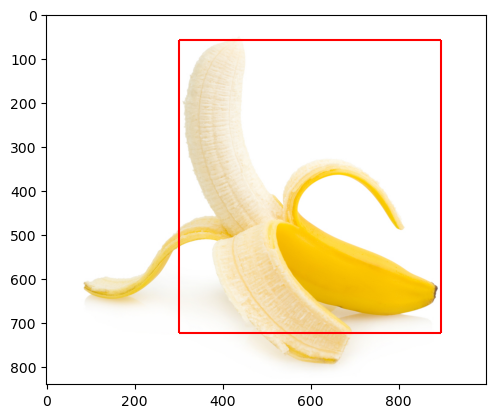

In [15]:
plot_picture_with_bbox('banana_2')

# Подготовка данных

Теперь приступим к работе с датасетом с помощью pytorch.

Сначала вам будет необходимо скачать Python-модуль `dataset.py`, который принимает в себя датасет Fruits и сам создает pytorch-датасет для работы с ним. Модуль доступен [по ссылке](https://edu.sirius.online/noo-back/files/16f7612e802d1a434e930da41046f3c7ce394b3c.py) (6 Кб).

Чтобы модуль стал доступен из этого блокнота, необходимо поместить скачанный файл `dataset.py` в одну директорию с блокнотом.

Возьмем модуль из скачанного файла, а также создадим словарь, который ставит в соответствие классам картинок их индексы, чтобы их закодировать.

In [2]:
from dataset import FruitDataset
class2tag = {"apple": 1, "orange": 2, "banana": 3}

Все картинки должны иметь одинаковый размер, чтобы работать с ними было удобно. Определим этот размер заранее.

In [3]:
WIDTH, HEIGHT = 448, 448

Перед обучением нашей модели нам будет необходимо провести аугментацию имеющихся изображений. Это поможет нам бороться с проблемой переобучения модели.

Если мы применим аугментации к картинкам из нашего датасета, то они изменятся. Однако измениться должны не только сами изображения, но и их прямоугольники (которые также называют bounding box). Получается, когда мы меняем положение банана в пространстве, мы должны применить аналогичное преобразование и к прямоугольнику на этом изображении.

Задача аугментации изображений вместе с их прямоугольниками уже решена в библиотеке `albumentations`. В ней собраны аугментации, применение которых к данным автоматически меняет прямоугольники так, чтобы они соответствовали изменениям. Попробуем создать датасет с аугментациями.

In [4]:
train_transform = Compose([
        # изменить размер изображения
        Resize(WIDTH, HEIGHT),
        # отражение по горизонтали 
        HorizontalFlip(p=0.5),
        # меняем яркость и контрастность изображения
        RandomBrightnessContrast(p=0.1)
    ],
    # указываем на наличие bounding_box
    bbox_params=BboxParams(format='yolo',
                           label_fields=['class_labels']))

val_transform = Compose([
        Resize(WIDTH, HEIGHT),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.2),
    ],
    bbox_params=BboxParams(format='yolo',
                           label_fields=['class_labels']))

NameError: name 'Compose' is not defined

Теперь соберём сами датасеты для обучения и валидации.

Как вы знаете, внутри YOLO каждое изображение разбивается на `S x S` блоков, каждый из которых генерирует `B` прямоугольников-кандидатов. Объекты на изображении могут относиться к одному из `C` классов. Именно данные параметры и передаются во FruitDataset.

Создадим датасет и даталоадеры по шаблону ниже.

Саначала нужно создать обучающий и валидационный датасеты.

In [ ]:
train_dataset = FruitDataset(
    transforms=train_transform,    # Аугментации обучающей выборки.
    class2tag=class2tag,           # Словарь классов и их индексов.
    data_dir="data/train/",        # Путь к данным для обучения.
    S=7, B=2, C=3,                 # Мы хотим иметь 7 секций по 2 прямоугольника в каждой.
    device=device                  # Перемещаем тензоры на соответствующее устройство.
    )

val_dataset = FruitDataset(
    transforms=val_transform,      # Аугментации валидационной выборки.
    class2tag=class2tag,           # Словарь классов и их индексов.
    data_dir="data/test/",         # Путь к данным для валидации.
    S=7, B=2, C=3,                 # Структура аналогична обучающей выборке.
    device=device                  # Перемещаем тензоры на соответствующее устройство.
    )

Из датасетов нужно создать даталоадеры — генераторы, которые формируют батчи картинок и выдают их. Если создавать их с флагом `shuffle=True`, то на каждой эпохе содержание батчей будет отличаться - объекты каждый раз будут перемешиваться. Также, с таким флагом нет никакой уверенности, что будет в каждом отдельном батче. Потому для стабильности необходимо зафиксировать все возможные случайности с помощью функции в ячейке ниже.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

Теперь создадим из датасетов даталоадеры.

In [ ]:
seed_everything(0)
train_dataloader = DataLoader(
    dataset=train_dataset,            # Обучающий датасет.
    batch_size=4,                     # Размер батча.
    shuffle=True,                     # Нужно ли перемешивать объекты.
)

val_dataloader = DataLoader(
    dataset=val_dataset,              # Валидационный датасет.
    batch_size=4,                     # Размер батча.
    shuffle=False,                    # Нужно ли перемешивать объекты.
)

Посмотрим на изображения после аугментаций.

In [ ]:
seed_everything(0)
batch = next(iter(train_dataloader))

In [ ]:
plt.imshow(batch[0][2].cpu());

Получившееся изображение выглядит довольно странно. Давайте поймём, что произошло. Изображение было отражено, и в нём изменились яркость и контрастность. Человеческому глазу с ходу трудно понять, что происходит на изображении. Однако для обучения моделей машинного обучения такая картинка вполне годится.

Тем не менее изображение можно вернуть в исходное состояние. Используем для этого модуль из `torchvision`.

In [ ]:
torchvision.transforms.ToPILImage()(batch[0][2].cpu().numpy().reshape(WIDTH, HEIGHT, 3).astype(np.uint8))

Датасеты готовы.

## Задание 2

Теперь поймём, как мы будем сравнивать прямоугольники. Для этого можно использовать рассмотреную в лекции метрику IoU — Intersection over Union. Данная метрика проста для понимания: берем площадь прямоугольника из пересечения предсказанного и правильного прямоугольников и делим её на площадь объединения двух прямоугольников. 

**Условие**

Реализуйте функцию для вычисления значения метрики IoU на основе шаблона в ячейке ниже.

In [8]:
def intersection_over_union(predicted_bbox, gt_bbox):
    """
    Вычисляет значение Intersection over Union для двух прямоугольников
    
    Аргументы:
        predicted_bbox: Предсказанный прямоугольник в формате [x_min, y_min, x_max, y_max].
        gt_bbox: Правильный прямоугольник в формате [x_min, y_min, x_max, y_max].

    Возвращаемое значение:
        Значение Intersection over Union.
    """

    # TODO: Пересечение двух прямоугольников, если оно есть, всегда будет прямоугольником.
    #       Вычислите координаты прямоугольника, который будет являться пересечением двух прямоугольников.
    intersection_x_min = max(predicted_bbox[0], gt_bbox[0])
    intersection_y_min = max(predicted_bbox[1], gt_bbox[1])
    intersection_x_max = min(predicted_bbox[2], gt_bbox[2])
    intersection_y_max = min(predicted_bbox[3], gt_bbox[3])

    # TODO: Вычислите площадь пересечения (может быть нулевой).
    intersection_area = (
            (intersection_x_max - intersection_x_min) * (intersection_y_max - intersection_y_min)   
            if (intersection_x_max > intersection_x_min) and (intersection_y_max > intersection_y_min)
            else 0
    )

    # TODO: Вычислите площадь предсказанного прямоугольника.
    area_pred = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])

    # TODO: Вычислите площадь правильного прямоугольника.
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    # TODO: Вычислите площадь объединения (помните, что пересечение дважды входит в сумму
    #       площадей двух прямоугольников).
    union_area = area_pred + area_gt - intersection_area

    # TODO: Вычислите значение IoU.
    iou = intersection_area / union_area
    return iou

Теперь нужно проверить, что все работает правильно. Возьмем уже известную нам картинку банана.

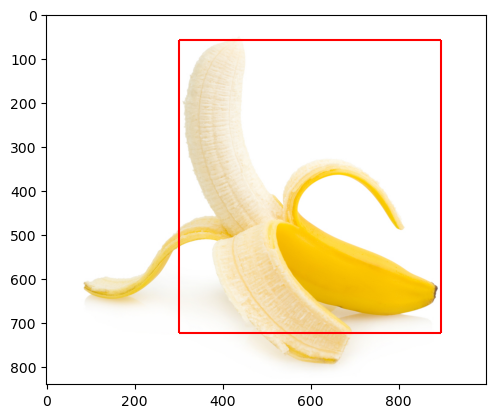

In [9]:
plot_picture_with_bbox('banana_2')

Добавим сюда еще один прямоугольник. В рамках тестирования функции будем считать, что именного его наша модель и предсказала.

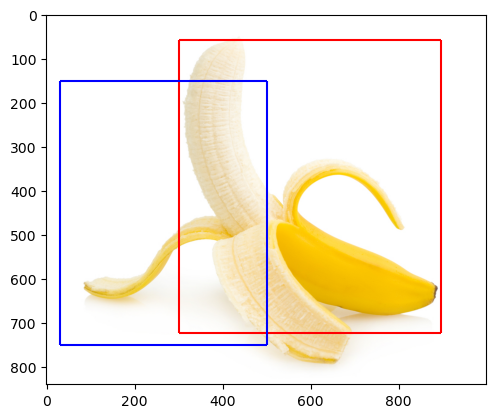

In [16]:
plot_picture_with_bbox('banana_2')
pred_bbox = [30, 150, 500, 700]
plt.vlines(30, 150, 750, color='blue')
plt.vlines(500, 750, 150, color='blue')
plt.hlines(150, 30, 500, color='blue')
plt.hlines(750, 500, 30, color='blue')
plt.show()

In [12]:
with open(f'dataset/fruits/train/banana_2.xml') as f:
    tmp = f.read()
tmp = xmltodict.parse(tmp)

coordinates = tmp['annotation']['object']['bndbox']

x_min = int(coordinates['xmin'])
y_min = int(coordinates['ymin'])
x_max = int(coordinates['xmax'])
y_max = int(coordinates['ymax'])

**Что нужно внести в систему**

Найдите IoU для этих двух прямоугольников. В качестве ответа выведите число, округлив его до 3 знаков после запятой.

In [13]:
target_bbox = [x_min, y_min, x_max, y_max]
print(round(intersection_over_union(target_bbox, pred_bbox), 3))

0.2


## Задание 3

Теперь скачайте веса предобученной модели. Это не совсем модель YOLO, так как настоящая такая модель весит очень много, что делает ее использование затруднительным в условиях ограниченных ресурсов.

Представленная модель является облегчённой версией YOLO, которая показывает несколько более скромные результаты, но все же даёт возможность довольно неплохо определять прямоугольники для изображений.

[Ссылка](https://disk.yandex.ru/d/vejo44MeMiaO6w) (**важно**, что модель всё равно весит (!) 840 Мб) на скачивание модели. Файл с моделью нужно разместить в одной директории с блокнотом.

Ниже приведена архитектура той модели, которую вы скачали.

In [17]:
# Свёрточный блок.
class CNNBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, is_max_pool=False, **kwargs):

        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_max_pool = is_max_pool
        self.max_pool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))
        if self.is_max_pool:
            x = self.max_pool(x)
        return x


# Сама облегчённая версия YOLO.
class YOLO(nn.Module):
    def __init__(self,
                 S=7,  # S * S - количество ячеек на которые разбивается изображение.
                 B=2,  # Количество прямоугольников-кандидатов в каждой ячейке.
                 C=3,  # Количество классов.
                 batch_size=1):

        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        self.conv1 = CNNBlock(in_channels=3, out_channels=64, kernel_size=7, is_max_pool=True, stride=2, padding=2)
        self.conv2 = CNNBlock(in_channels=64, out_channels=32, kernel_size=3, is_max_pool=True)
        self.conv3 = CNNBlock(32, 16, kernel_size=3)

        self.fc1 = nn.Linear(43264, 100 * S * S)
        self.fc2 = nn.Linear(100 * S * S, S * S * (5 * B + C))
        self.dropout = nn.Dropout(0.1)
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        if len(x.shape) == 3:
            # на случай если всего один объект на вход, а не батч => батч размера 1
            x = torch.unsqueeze(x, dim=0)
        x = x.reshape(-1, 3, 448, 448)
        batch_size = x.shape[0]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.leakyrelu(x)
        x = self.fc2(x)
        x = x.reshape((batch_size, self.S, self.S, (self.B * 5 + self.C)))
        return x

In [18]:
# Загружаем модель из файла.
model = torch.load('best_model_50.h')

FileNotFoundError: [Errno 2] No such file or directory: 'best_model_50.h'

Теперь у нас есть модель с весами, которые уже подстроились под наш датасет. Модель обучалась на наших данных в течение 50 эпох.

Давайте посмотрим на то, что модель выдает на выходе для случайной картинки из валидационной выборки

In [ ]:
seed_everything(0)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=5,
    shuffle=True
)

In [ ]:
seed_everything(1)
batch = next(iter(val_dataloader))

In [ ]:
image = batch[0][1].cpu()
target = batch[1][1].cpu()

Посмотрим на случайное изображение.

In [ ]:
torchvision.transforms.ToPILImage()(image.numpy().reshape(WIDTH, HEIGHT, 3).astype(np.uint8))

На изображении должен быть апельсин. Это нам гарантирует то, что в процессе извлечения данных из датасета мы с помощью функции `seed_everything` фиксировали случайность выбора данных.

**Условие**

С помощью модели YOLO, которая хранится в переменной `model`, сделайте предсказание для изображения `image`.

In [ ]:
# TODO: Необходимо реализовать предсказание модели для изображения `image`.
preds = ...

Изучим, как выглядит наше предсказание.

In [ ]:
preds

Результатом работы модели для одного объекта, как было рассмотрено в лекции, является набор блоков. Каждому из них сопоставлены прямоугольники-кандидаты и набор вероятностей принадлежностей блока различным классам. Однако из-за того, что `model` делает предсказание для целого батча, в выходной тензор добавляется внешняя размерность. 

То есть ожидаемый размер выходного тензора — $(N_{batches}, \ S, \ S, \ (5 \cdot B + C))$.

In [ ]:
preds.shape

**Что нужно внести в систему**

В качестве ответа на задание найдите среднее значение по всему тензору предсказанных значений и округлите его до 3 знаков после запятой. Для этого заполните пропуск в ячейке ниже и запустите её.

**Рекомендации по решению**

Для того чтобы достать из тензора конкретное число, вам может понадобиться функция `item`. Она превращает тензор из одного зачения в это значение:

```python3
a = torch.tensor(1)

print(a)         # tensor(1)
print(a.item())  # 1
```

In [ ]:
# TODO: Необходимо вычислить среднее значение по всему тензору предсказанных
#       значений и округлить его до 3 знаков после запятой. 
round(..., 3)

## Задание 4

Работать с таким представлением прямоугольников трудно. Поэтому мы преобразуем полученный тензор к привычному нам виду прямоугольника.

Для этого воспользуемся уже реализованным Python-модулем `boxes`, который доступен [по ссылке](https://edu.sirius.online/noo-back/files/03f641023a82cd23dfa5b5d0c38e2c4f2f86ea71.py). Так же, как и раньше, нужно скачать файл по ссылке и поместить его в директорию с блокнотом.

In [ ]:
from boxes import get_bound_boxes

Функция `get_bound_boxes` сама сделает с помощью `model` предсказание для изображения, а также обработает выход — возьмёт все возможные прямоугольники и проверит их на пересечения (не имеет смысла выводить два прямоугольника, которые сильно пересекаются).

In [ ]:
seed_everything(123)
pred_bbox = get_bound_boxes(images=image, model=model, iou=intersection_over_union, iou_threshold=.5, conf_threshold=.4)

Теперь нужно преобразовать предсказанные прямоугольники в используемый нами формат.

In [ ]:
predictions_bboxes = []
for box in pred_bbox:
    x_min = abs(box[0] * WIDTH - int((box[2] * WIDTH / 2)))
    x_max = abs(box[0] * WIDTH + int((box[2] * WIDTH / 2)))
    y_min = abs(box[1] * HEIGHT - int((box[3] * HEIGHT/ 2)))
    y_max = abs(box[1] * HEIGHT + int((box[3] * HEIGHT/ 2)))
    bbox = [x_min, y_min, x_max, y_max]
    predictions_bboxes += [bbox]

Правильные прямоугольники тоже нужно привести к данному формату.

In [ ]:
target_bboxes = []
for cell in target.reshape(7*7, 13):
    for box_ind in range(0, 10, 5):
        pos_box = cell[box_ind:box_ind+5]
        if sum(pos_box) != 0:
            x_min = pos_box[0] * WIDTH - int((pos_box[2] * WIDTH / 2))
            x_max = pos_box[0] * WIDTH + int((pos_box[2] * WIDTH / 2))
            y_min = pos_box[1] * HEIGHT - int((pos_box[3] * HEIGHT/ 2))
            y_max = pos_box[1] * HEIGHT + int((pos_box[3] * HEIGHT/ 2))
            bbox = [x_min, y_min, x_max, y_max]
            target_bboxes += [bbox]

Теперь мы можем нарисовать настоящий прямоугольник и предсказанный нашей моделью.

In [ ]:
def plot_pic_with_bboxes(picture, tgt_bbox, pred_bbox):
    img = torchvision.transforms.ToPILImage()(image.numpy().reshape(WIDTH, HEIGHT, 3).astype(np.uint8))
    plt.imshow(img)

    plt.vlines(pred_bbox[0], pred_bbox[1], pred_bbox[3], color='blue')
    plt.vlines(pred_bbox[2], pred_bbox[3], pred_bbox[1], color='blue')
    plt.hlines(pred_bbox[1], pred_bbox[0], pred_bbox[2], color='blue')
    plt.hlines(pred_bbox[3], pred_bbox[2], pred_bbox[0], color='blue')

    plt.vlines(tgt_bbox[0], tgt_bbox[1], tgt_bbox[3], color='red')
    plt.vlines(tgt_bbox[2], tgt_bbox[3], tgt_bbox[1], color='red')
    plt.hlines(tgt_bbox[1], tgt_bbox[0], tgt_bbox[2], color='red')
    plt.hlines(tgt_bbox[3], tgt_bbox[2], tgt_bbox[0], color='red')

In [ ]:
plot_pic_with_bboxes(image, target_bboxes[0], predictions_bboxes[0])

Видим, что наше предсказание (синий прямоугольник) пересекается с правильным прямоугольником (красный прямоугольник). Однако ошибка предсказания всё равно существенная.

Давайте поймём, насколько наше предсказание далеко от реальности. Для этого воспользуемся метрикой IoU.

**Условие**

Рассчитайте значение метрики IoU для прямоугольников, которые получились в `predictions_bboxes` и `target_bboxes`.

Если вдруг в `predictions_bboxes` и/или `target_bboxes` есть больше одного прямоугольника, то считайте метрику только для двух первых прямоугольников в массиве(-ах). Аналогично тому, как строилось изображение выше.

**Что нужно внести в систему**

В качестве ответа на задание введите значение метрики, округлённое до 3-х знаков после запятой. Для этого заполните пропуск в ячейке ниже и запустите её.

In [ ]:
# TODO: Необходимо вычислить  значение метрики IoU и округлить его до 3 знаков после запятой. 
round(..., 3)